In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd

In [4]:
TRAIN_DATA_FILE = 'https://raw.githubusercontent.com/rosagradilla19/CarAccidentNN/master/train_2.csv'
TEST_DATA_FILE = 'https://raw.githubusercontent.com/rosagradilla19/CarAccidentNN/master/test_2.csv'

train_file_path = tf.keras.utils.get_file('train_2.csv', TRAIN_DATA_FILE)
test_file_path = tf.keras.utils.get_file('test_2.csv', TEST_DATA_FILE)

1253376/1252455 [==============================] - 1s 1us/step


In [5]:
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

In [10]:
df = pd.read_csv(TRAIN_DATA_FILE)

len(df.injSeverity.unique())

7

In [76]:
LABEL_COLUMN = 'injSeverity'
LABELS = [3., 1., 4., 0., 2., 5., 6.]

In [50]:
def get_dataset(file_path, **kwargs):
  dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=32, # Artificially small to make examples easier to show.
      label_name=LABEL_COLUMN,
      na_value="?",
      num_epochs=1,
      ignore_errors=True, 
      **kwargs)
  return dataset

raw_train_data = get_dataset(train_file_path, select_columns=SELECT_COLUMNS)
raw_test_data = get_dataset(test_file_path, select_columns=SELECT_COLUMNS)

In [13]:
def show_batch(dataset):
  for batch, label in dataset.take(1):
    for key, value in batch.items():
      print("{:20s}: {}".format(key,value.numpy()))

In [26]:
show_batch(raw_train_data)

dvcat               : [b'10-24' b'10-24' b'25-39' b'25-39' b'10-24']
weight              : [   5.728   64.31    37.71    18.465 2660.682]
dead                : [b'alive' b'alive' b'alive' b'alive' b'alive']
airbag              : [b'airbag' b'none' b'airbag' b'airbag' b'none']
seatbelt            : [b'belted' b'belted' b'belted' b'belted' b'none']
frontal             : [0 1 0 1 1]
sex                 : [b'm' b'f' b'm' b'f' b'm']
ageOFocc            : [23 43 17 16 42]
yearacc             : [1997 1997 1997 1997 1997]
yearVeh             : [1995. 1978. 1991. 1992. 1979.]
abcat               : [b'nodeploy' b'unavail' b'deploy' b'deploy' b'unavail']
occRole             : [b'pass' b'driver' b'driver' b'driver' b'driver']
deploy              : [0 0 1 1 0]


# Data Processing

In [24]:
SELECT_COLUMNS = ['dvcat', 'weight', 'dead', 'airbag', 'seatbelt',
       'frontal', 'sex', 'ageOFocc', 'yearacc', 'yearVeh', 'abcat', 'occRole',
       'deploy','injSeverity']

## Continuous data

In [16]:
NUMERIC_FEATURES = ['weight','ageOFocc','yearacc','yearVeh','frontal','deploy']

In [18]:
# Preprocessor that selects a list of numeric features and packs
# into a single column

class PackNumericFeatures(object):
  def __init__(self, names):
    self.names = names

  def __call__(self, features, labels):
    numeric_features = [features.pop(name) for name in self.names]
    numeric_features = [tf.cast(feat, tf.float32) for feat in numeric_features]
    numeric_features = tf.stack(numeric_features, axis=-1)
    features['numeric'] = numeric_features

    return features, labels

In [51]:
packed_train_data = raw_train_data.map(
    PackNumericFeatures(NUMERIC_FEATURES))

packed_test_data = raw_test_data.map(
    PackNumericFeatures(NUMERIC_FEATURES))

In [75]:
#show_batch(packed_train_data)

In [31]:
example_batch, labels_batch = next(iter(packed_train_data)) 

### Data Normalization

In [32]:
import pandas as pd
desc = pd.read_csv(train_file_path)[NUMERIC_FEATURES].describe()
desc

,weight,ageOFocc,yearacc,yearVeh,frontal,deploy
count,12963.000000,12963.000000,12963.000000,12963.000000,12963.000000,12963.000000
mean,445.180672,37.287665,1998.058783,1991.342205,0.640130,0.287588
std,1593.256321,17.962704,0.826819,5.330114,0.479981,0.452655
min,0.000000,16.000000,1997.000000,1959.000000,0.000000,0.000000
25%,31.155000,22.000000,1997.000000,1988.000000,0.000000,0.000000
50%,76.653000,33.000000,1998.000000,1992.000000,1.000000,0.000000
75%,330.857000,48.000000,1999.000000,1996.000000,1.000000,1.000000
max,57871.595000,97.000000,2000.000000,2000.000000,1.000000,1.000000


In [33]:
MEAN = np.array(desc.T['mean'])
STD = np.array(desc.T['std'])

In [34]:
def normalize_numeric_data(data, mean, std):
  # Center the data
  return (data-mean)/std

In [53]:
from functools import partial

normalizer = partial(normalize_numeric_data, mean=MEAN, std=STD)

numeric_column = tf.feature_column.numeric_column('numeric', normalizer_fn=normalizer, shape=[len(NUMERIC_FEATURES)])
numeric_columns = [numeric_column]
numeric_column

NumericColumn(key='numeric', shape=(6,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function normalize_numeric_data at 0x1080bf200>, mean=array([ 445.181,   37.288, 1998.059, 1991.342,    0.64 ,    0.288]), std=array([1593.256,   17.963,    0.827,    5.33 ,    0.48 ,    0.453])))

In [54]:
example_batch['numeric']

<tf.Tensor: shape=(5, 6), dtype=float32, numpy=
array([[  81.996,   76.   , 1997.   , 1995.   ,    1.   ,    1.   ],
       [  92.285,   55.   , 1998.   , 1997.   ,    1.   ,    1.   ],
       [  33.288,   26.   , 1997.   , 1989.   ,    0.   ,    0.   ],
       [ 169.829,   47.   , 1997.   , 1985.   ,    1.   ,    0.   ],
       [  34.053,   65.   , 1997.   , 1994.   ,    1.   ,    1.   ]],
      dtype=float32)>

In [55]:
numeric_layer = tf.keras.layers.DenseFeatures(numeric_columns)
numeric_layer(example_batch).numpy()

array([[-0.228,  2.155, -1.281,  0.686,  0.75 ,  1.574],
       [-0.221,  0.986, -0.071,  1.061,  0.75 ,  1.574],
       [-0.259, -0.628, -1.281, -0.439, -1.334, -0.635],
       [-0.173,  0.541, -1.281, -1.19 ,  0.75 , -0.635],
       [-0.258,  1.543, -1.281,  0.499,  0.75 ,  1.574]], dtype=float32)

## Categorical Data

In [56]:
categorical_columns=[]

cat_i_c = ['dvcat','dead', 'airbag', 'seatbelt', 'sex', 'occRole']

for feature_name in cat_i_c:
  vocabulary = df[feature_name].unique()
  cat_c = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)
  one_hot = tf.feature_column.indicator_column(cat_c)
  categorical_columns.append(one_hot)

In [57]:
categorical_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='dvcat', vocabulary_list=('25-39', '10-24', '40-54', '55+', '1-9km/h'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='dead', vocabulary_list=('alive', 'dead'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='airbag', vocabulary_list=('none', 'airbag'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='seatbelt', vocabulary_list=('belted', 'none'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('f', 'm'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='occRole', vocabulary_list=('driver', 'pass'

### Combined Preprocessing Layer

In [58]:
preprocessing_layer = tf.keras.layers.DenseFeatures(categorical_columns+numeric_columns)

In [59]:
print(preprocessing_layer(example_batch).numpy()[0])

[ 0.     1.     1.     0.     1.     0.     0.     0.     0.    -0.228
  2.155 -1.281  0.686  0.75   1.574  0.     1.     1.     0.     1.
  0.   ]


## Build the Model

In [66]:
model = tf.keras.Sequential([
  preprocessing_layer,
  tf.keras.layers.Dense(60, activation='relu'),
  tf.keras.layers.Dense(60, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(7, activation='softmax')
])

#tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train, evaluate, and predict

In [61]:
train_data = packed_train_data.shuffle(500)
test_data = packed_test_data

In [67]:
model.fit(train_data, epochs=10)

Epoch 1/10
406/406 [==============================] - 4s 9ms/step - loss: 1.7620 - accuracy: 0.4011
Epoch 2/10
406/406 [==============================] - 1s 3ms/step - loss: 1.7149 - accuracy: 0.4467
Epoch 3/10
406/406 [==============================] - 1s 3ms/step - loss: 1.7069 - accuracy: 0.4502
Epoch 4/10
406/406 [==============================] - 1s 3ms/step - loss: 1.7031 - accuracy: 0.4533
Epoch 5/10
406/406 [==============================] - 1s 3ms/step - loss: 1.6917 - accuracy: 0.4641
Epoch 6/10
406/406 [==============================] - 1s 3ms/step - loss: 1.6583 - accuracy: 0.4987
Epoch 7/10
406/406 [==============================] - 1s 3ms/step - loss: 1.6580 - accuracy: 0.4968
Epoch 8/10
406/406 [==============================] - 1s 3ms/step - loss: 1.6556 - accuracy: 0.4989
Epoch 9/10
406/406 [==============================] - 1s 3ms/step - loss: 1.6524 - accuracy: 0.5057
Epoch 10/10
406/406 [==============================] - 1s 3ms/step - loss: 1.6527 - accuracy: 0.5061

In [68]:
test_loss, test_accuracy = model.evaluate(test_data)

print('\n\nTest Loss {}, Test Accuracy {}'.format(test_loss, test_accuracy))

    410/Unknown - 3s 7ms/step - loss: 1.6651 - accuracy: 0.4897

Test Loss 1.6650657208954416, Test Accuracy 0.48969465494155884


## Confusion Matrix

In [69]:
predictions = model.predict(test_data)

In [94]:
pred = []
for row in predictions:
    index = np.argmax(row)
    pred.append(index)
    
pred = np.array(pred)
pred.shape

(13100,)

In [95]:
pred[:20]

array([3, 3, 0, 3, 3, 1, 3, 1, 3, 0, 4, 0, 0, 3, 0, 3, 3, 3, 3, 3])

In [101]:
test_df = pd.read_csv('https://raw.githubusercontent.com/rosagradilla19/CarAccidentNN/master/test_2.csv')

labels = test_df['injSeverity']
labels_np = np.array(labels)

labels_np.shape

(13100,)

In [112]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true= labels_np, y_pred=pred)

In [113]:
# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

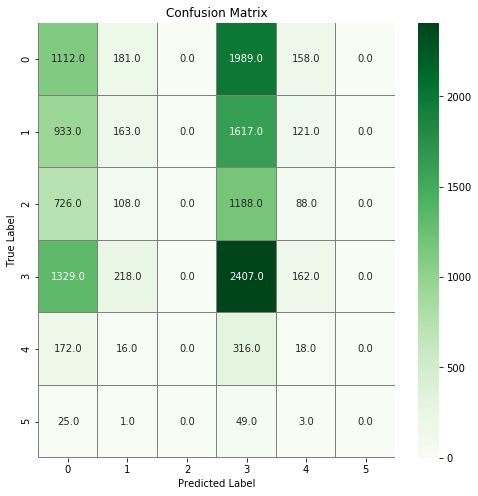

In [114]:
f,ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_matrix, annot=True,
           linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()